In [134]:
import os
import itertools
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, recall_score, RocCurveDisplay
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [135]:
data_root = Path(os.getcwd()).parent.parent / 'data'
data_path = data_root / 'train-metadata.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

In [136]:
num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient'] + [f'{col}_count' for col in cat_cols] + [(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)]
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [137]:
def apply_feature_engineering(df_pd, medians=None):
    '''Feature engineering, will be applied on train and test set.'''
    pl_df = pl.from_pandas(df_pd)
    float_cols = pl_df.select(pl.col(pl.Float64)).columns
    if medians is None:
        medians = {col: pl_df.select(pl.col(col).median()).item() for col in float_cols}

    # Imputing nans with medians from train set
    pl_df = pl_df.with_columns([
        pl.col(col).fill_nan(medians.get(col, 0)) for col in float_cols
    ])

    pl_df = (
        pl_df
        .with_columns(
            pl.col('age_approx').cast(pl.String).cast(pl.Float64),
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            ((pl.col(num_col) - pl.col(num_col).mean().over('patient_id', cat_col)) / (pl.col(num_col).std().over('patient_id', cat_col) + err)).alias(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)
        )
        .with_columns(
            pl.col(col).count().over('patient_id', col).alias(f'{col}_count') for col in cat_cols
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )
    return pl_df, medians

In [138]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [139]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [140]:
def custom_split(data_path):
    df = pd.read_csv(data_path)
    X = df
    y = df['target']
    groups = df[group_col]
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

    # splitter.split() returns tuple of indices
    for train_idx, test_idx in splitter.split(X, y, groups):
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_test = df.iloc[test_idx].reset_index(drop=True)
        return df_train, df_test

In [141]:
df_train, df_test = custom_split(data_path)
df_train, train_medians = apply_feature_engineering(df_train)
df_test, _ = apply_feature_engineering(df_test, train_medians)
df_train, df_test = preprocess(df_train, df_test)

In [142]:
print('df_train shape:', df_train.shape)
print('df_test shape:', df_test.shape)

df_train shape: (319514, 431)
df_test shape: (81545, 431)


In [143]:
print(df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]))

0.7966758008173361


In [144]:
df_train['patient_id'].unique().shape

(833,)

In [145]:
df_test['patient_id'].unique().shape

(209,)

In [146]:
209 / 1042

0.20057581573896352

In [147]:
print(f'Malignant count df_train: {df_train[df_train['target'] == 1].shape[0]}')
print(f'Malignant count df_test: {df_test[df_test['target'] == 1].shape[0]}')

Malignant count df_train: 283
Malignant count df_test: 110


In [148]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'n_jobs':           2,
    'boosting_type':    'gbdt',
    'lambda_l1':        0.03335206514282942, 
    'lambda_l2':        0.005157393323802471, 
    'learning_rate':    0.030665870185795318, 
    'max_depth':        7, 
    'num_leaves':       239, 
    'colsample_bytree': 0.7573175155547233, 
    'colsample_bynode': 0.5005423904042993, 
    'bagging_fraction': 0.7937347683420382, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 29, 
    'scale_pos_weight': 1.648349898918236,
}

# estimator = Pipeline([
#     ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
#     ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=12)),
# ])

estimator = VotingClassifier([
    ('lgb1', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=12)),
    ])),
    ('lgb2', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=22)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=22)),
    ])),
    ('lgb3', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=32)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=32)),
    ])),
    ('lgb4', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=42)),
    ])),
    ('lgb5', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=52)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=52)),
    ])),
], voting='soft')

In [149]:
X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col] 
groups = df_train[group_col]

cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)
# val_score = cross_val_score(
#     estimator=estimator, 
#     X=X_train, y=y_train,
#     cv=cv, 
#     groups=groups,
#     scoring=custom_metric,
# )

# np.mean(val_score), val_score

In [150]:
def plot_cm(model, X_train, y_train, X_val, y_val, fold_num, experiment_num, threshold=0.5, test=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    datasets = [(X_train, y_train, 'Train'), (X_val, y_val, 'Test' if test else 'Validation')]
    
    for ax, (X_data, y_true, name) in zip(axes, datasets):
        y_probs = model.predict_proba(X_data)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        group_names = ['TN', 'FP', 'FN', 'TP']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False,
                    xticklabels=['Benign (0)', 'Malignant (1)'],
                    yticklabels=['Benign (0)', 'Malignant (1)'])
        
        ax.set_title(f'Fold {fold_num} - {name}')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    save_dir = Path(f'../../images/gbdt/{experiment_num}')
    save_dir.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_dir / f'cm_fold_{fold_num}.jpg')
    plt.show()

In [156]:
def evaluate(estimator, X_test, y_test, threshold=0.5):
    y_proba = estimator.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return classification_report(y_test, y_pred, output_dict=True), custom_metric(estimator, X_test, y_test)

### Cross-Validation

In [152]:
dirs = os.listdir(Path(os.getcwd()).parent.parent / 'images/gbdt')
if len(dirs) == 0:
    experiment_num = 0
else:
    experiment_num = max([int(i) for i in dirs]) + 1
experiment_num

12

---[ Fold 1 ]---


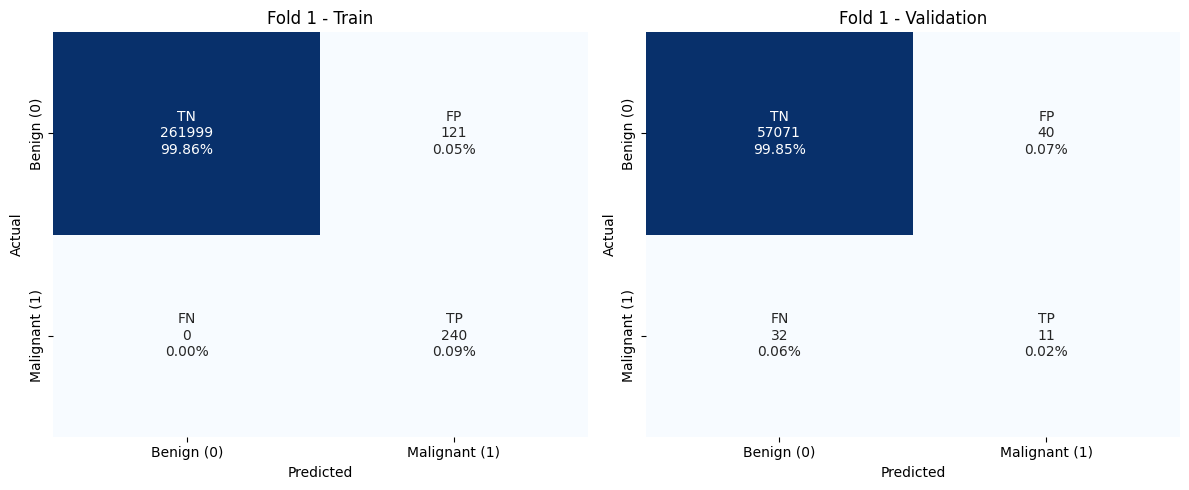

---[ Fold 2 ]---


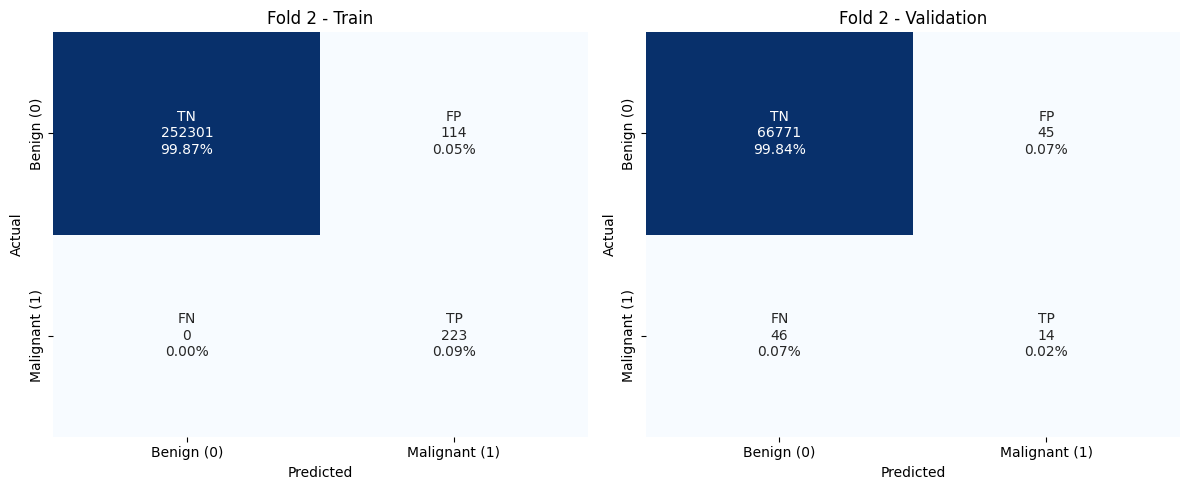

---[ Fold 3 ]---


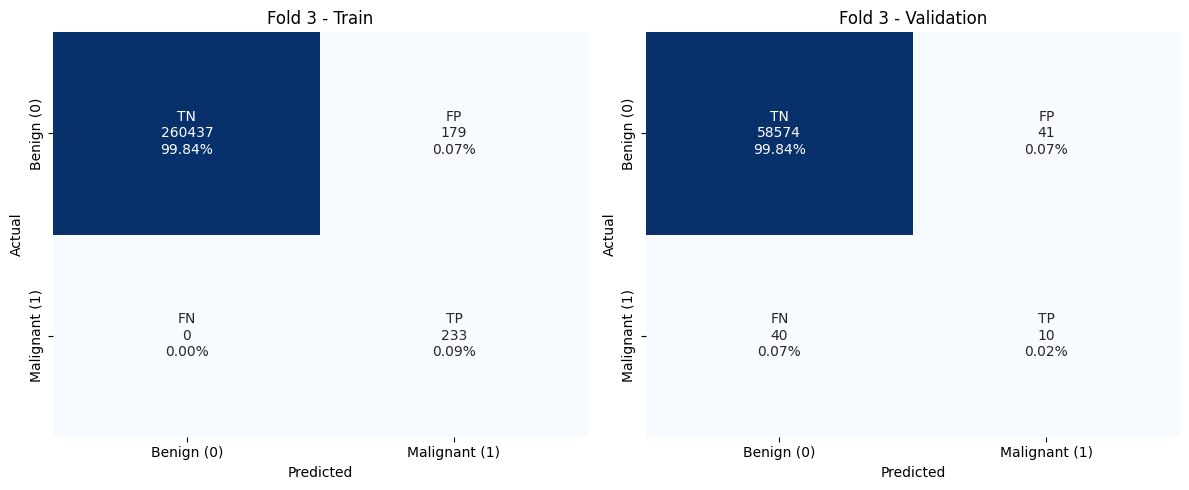

---[ Fold 4 ]---


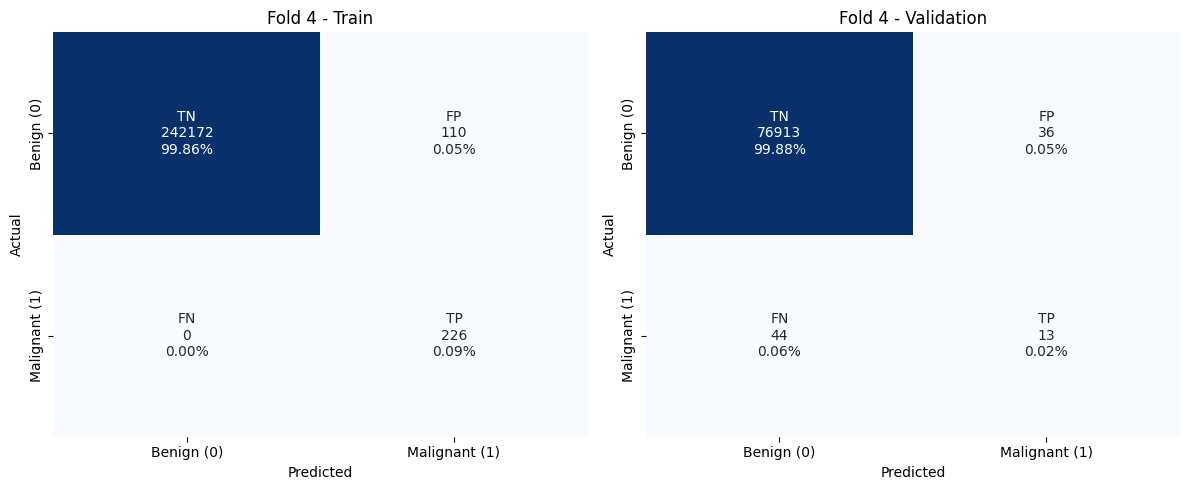

---[ Fold 5 ]---


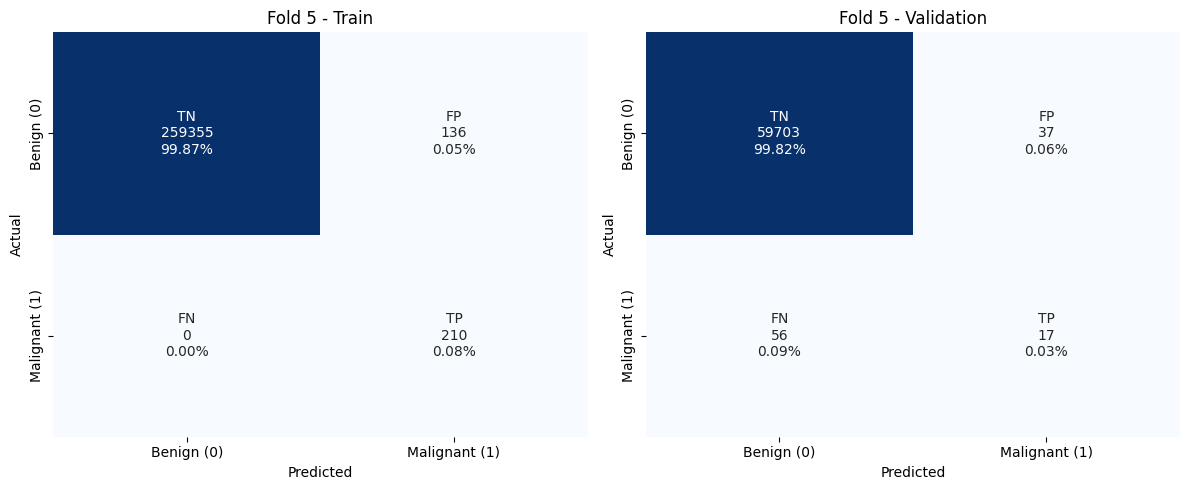

In [153]:
exp_data = {'experiment_num': experiment_num,
            'data': []}

sampling_ratio = 0.01

models = []
cv_scores = []
threshold = 0.5
for fold, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train, groups=groups)):
    print(f'---[ Fold {fold + 1} ]---')

    X_train_cv, X_val_cv = X_train.iloc[train_indices], X_train.iloc[val_indices]
    y_train_cv, y_val_cv = y_train.iloc[train_indices], y_train.iloc[val_indices]

    estimator.fit(X_train_cv, y_train_cv) 
    y_probs = estimator.predict_proba(X_val_cv)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    score = custom_metric(estimator, X_val_cv, y_val_cv)
    report_dict = classification_report(y_val_cv, y_pred, output_dict=True)

    fold_data = {
        "fold": fold + 1,
        "metrics": report_dict,
        "partial_auc": score,
    }

    exp_data['data'].append(fold_data)
    cv_scores.append(score)
    models.append(estimator)

    plot_cm(estimator, X_train_cv, y_train_cv, X_val_cv, y_val_cv, fold + 1, experiment_num, threshold=threshold)

### Writing to experiments.md

Mean partial AUC: 0.1747


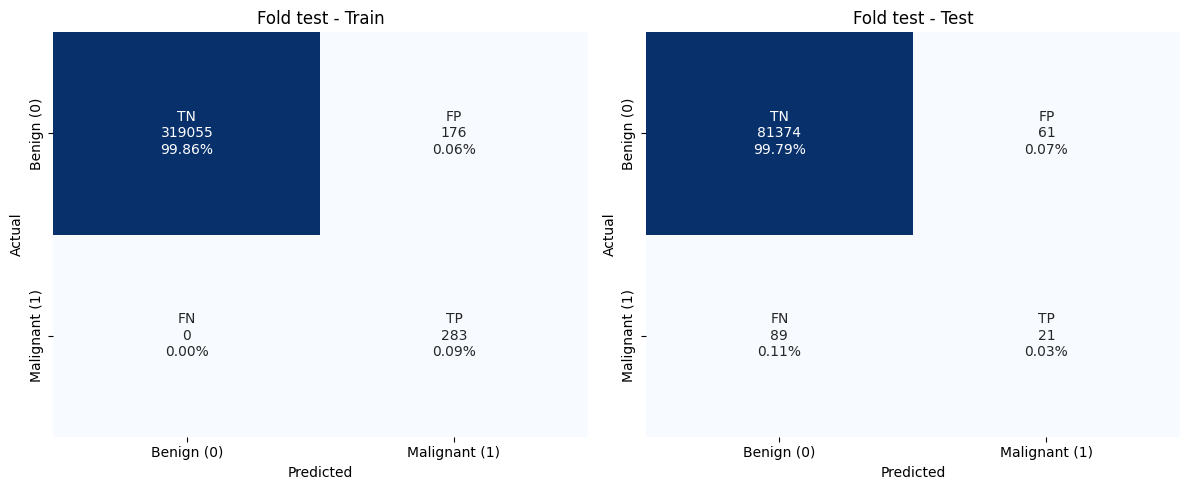

In [157]:
estimator.fit(X_train, y_train)
test_report_dict, test_partial_auc = evaluate(estimator, X_test, y_test)

changes = 'Switched to VotingClassifier with 5 lgbs'
mean_pauc = np.mean(cv_scores)
std_auc = np.std(cv_scores)
history_file = 'experiments.md'

print(f'Mean partial AUC: {mean_pauc:.4f}')

with open(history_file, 'a') as f:
    f.write(f"# Experiment: {experiment_num}\n")
    f.write(f"> {changes}\n")
    f.write(f"- **Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Mean Partial AUC:** `{mean_pauc:.4f} +/- {std_auc:.4f}`\n")
    f.write(f"- **Threshold:** `{threshold}`\n\n")

    f.write("## Model Configuration\n")
    f.write(f"```python\n{repr(estimator)}\n```\n\n")

    f.write("## Fold Results\n")
    
    for fold_info in exp_data['data']:
        f_num = fold_info['fold']
        f.write(f"### Fold {f_num}\n")
        f.write(f"- **Fold Partial AUC:** `{fold_info['partial_auc']:.4f}`\n\n")
        
        f.write("| Precision | Recall | F1-Score |\n")
        f.write("| :--- | :--- | :--- |\n")
        
        data = fold_info['metrics']['1']
        f.write(f'| {data['precision']:.4f} | {data['recall']:.4f} | {data['f1-score']:.4f} |\n')
        
        f.write("\n")

        img_path = f"../../images/gbdt/{experiment_num}/cm_fold_{f_num}.jpg"
        f.write(f"#### Confusion Matrix Fold {f_num}\n")
        f.write(f"![CM Fold {f_num}]({img_path})\n\n")
        
        f.write("---\n")

    f.write('### Test set\n')

    plot_cm(estimator, X_train, y_train, X_test, y_test, 'test', experiment_num, test=True)
    
    f.write(f"- **Test Partial AUC:** `{test_partial_auc:.4f}`\n\n")
    
    f.write("| Precision | Recall | F1-Score |\n")
    f.write("| :--- | :--- | :--- |\n")
    
    data = test_report_dict['1']
    f.write(f'| {data['precision']:.4f} | {data['recall']:.4f} | {data['f1-score']:.4f} |\n')
    
    f.write("\n")

    img_path = f"../../images/gbdt/{experiment_num}/cm_fold_test.jpg"
    f.write(f"#### Confusion Matrix Test\n")
    f.write(f"![CM Fold Test]({img_path})\n\n")
    
    f.write("---\n")

    f.write("\n\n")